In [8]:
from sklearn.model_selection import cross_val_score
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
# ^^^ pyforest auto-imports - don't write above this line
import pyforest

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import matplotlib.pyplot as pt
import seaborn

import time 

from sklearn.preprocessing import label_binarize
#modeles :
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier

import warnings
import os

warnings.filterwarnings("ignore")

# Préparation de données :

In [17]:
path_csv = "D:\\etude_data_science\\Kaggle_competition\\03_Multi-Class Prediction of Obesity Risk\\dataset\\"

In [18]:
data_cleaned = pd.read_csv(path_csv+"final_df.csv")
df = data_cleaned.copy()

In [19]:
#Gardons l'id des lignes pour plus tard
identifiant = df["id"]

In [20]:
X,y = df.drop(columns=["id", "NObeyesdad"], axis = 1), df["NObeyesdad"]

In [21]:
X_train, X_test,y_train,y_test = train_test_split(X,y, random_state=42)

### Encodage de la target

In [22]:
encoder = LabelEncoder()
encoder.fit(y_train)

<IPython.core.display.Javascript object>

LabelEncoder()

In [23]:
y_train, y_test = encoder.transform(y_train), encoder.transform(y_test)

##### Enregistrement de l'encoder de la target : 

In [24]:
with open('target_encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

<IPython.core.display.Javascript object>

In [25]:
print("Dimensions après split des données :\n")
print(f"X train :{X_train.shape}")
print(f"y train :{y_train.shape}")
print()
print(f"X test :{X_test.shape}")
print(f"y test :{y_test.shape}")

Dimensions après split des données :

X train :(15568, 20)
y train :(15568,)

X test :(5190, 20)
y test :(5190,)


# Plan : 

#### 1. Création des fonctions de modélisation 

#### 2. Entrainement et enregistrement des modèles

#### 3. Résultats et premières selection de modèles

#### 4. Visualisation des autres metrics

#### 5. Amélioration des modèles par GridSearchCV

#### 6. Visualisation des performances

#  1. Création des fonctions de modélisation

In [26]:
def train(model):
    """Fonction qui entraine un modèle et affiche le score obtenu sur 5 splits après
    cross validation et le score moyen. 
    Renvoi un tuple de trois éléments :
    (predictions, temps d'execution, le modèle entrainé)"""
    
    scores = cross_val_score(estimator=model, X=X_train.values, y=y_train)
    
    start_time = time.time()
    OneVsRestClassifier(model.fit(X_train,y_train))
    end_time = time.time()
    
    # durée totale de l'entrainement 
    training_time = round(end_time - start_time,2)
    
    # Durée en minute :
    training_time_min = round(training_time/60,2)

    yp = model.predict(X_test.values)
    
    print(type(model).__name__)
    print("Scores sur 5 splits : ", [i.round(3) for i in scores])
    print("Score moyen", scores.mean().round(3))

    return (yp, training_time_min, model)

In [27]:
def metric(prediction, model_name, exe_time):
    """Fonction qui renvoie un objet pandas Series contenant les valeurs des metrics
    principales : f1 score, accuracy, recall, precision score et le temps d'execution
    à partir de la liste des prédictions d'un modèle"""
    
    f1 = metrics.f1_score(y_true = y_test, y_pred = prediction, average='weighted')
    accuracy = metrics.accuracy_score(y_true = y_test, y_pred = prediction)
    recal = metrics.recall_score(y_true = y_test, y_pred = prediction, average='weighted')
    precision = metrics.precision_score(y_true = y_test, y_pred = prediction, average='weighted')
    
    all_metric = [f1,accuracy,recal,precision, exe_time]
    
    index_metric = ["F1","accuracy","recall","precision","duree_entrainement(min)"]
    
    series = pd.Series(all_metric, name=str(model_name), index=index_metric)
    return pd.DataFrame(series)
    

In [28]:
def matrice(prediction):
    cf = metrics.confusion_matrix(y_true=y_test, y_pred=prediction)
    plt.figure(figsize=(4,4))
    ax = sns.heatmap(cf, annot = True, linewidths=0.8, linecolor="black", fmt = ".0f",cbar=False, cmap = "Blues")
    ax.set_xlabel('Prédictions')
    ax.set_ylabel('Valeurs réelles')
    plt.title("Confusion Matrix")
    plt.show()

In [29]:
def ROC(model):
    """Fonction pour obtenir la courbe ROC pour la classification multiclasse"""
    n_classes = len(np.unique(y_test))
    # Binarisez les étiquettes (labels) pour pouvoir les utiliser dans roc_curve
    y_test_binarized = label_binarize(y_test, classes=model.classes_)
    predicted_probabilities = model.predict_proba(X_test.values)

    # Initialisez la figure pour le tracé
    plt.figure(figsize=(10, 8))

    # Calculez la courbe ROC pour chaque classe
    for i in range(len(model.classes_)):
        fpr, tpr, _ = metrics.roc_curve(y_test_binarized[:, i], predicted_probabilities[:, i])
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Classe {model.classes_[i]} (AUC = {roc_auc:.2f})')

    # Tracer la ligne en pointillés représentant la performance aléatoire
    plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Aléatoire')

    # Ajoutez des légendes, un titre et des étiquettes d'axe
    plt.legend(loc="lower right")
    plt.xlabel('Taux de faux positifs (FPR)')
    plt.ylabel('Taux de vrais positifs (TPR)')
    plt.title('Courbe ROC pour un problème de classification multiclasse')
    plt.grid(True)
    plt.show()

In [61]:
def GRID(model, param_grid):
    """Fonction qui entraine un modèle sur 5 splits
    Renvoie un tuple contenant :
    les prédictions du meilleur modèle après un entrainement par GridSearchCV ainsi que le meilleur modèle obtenue
    et la durée d'entrainement
    (prediction, tps_entrainement, meilleur_model)
    """
    #Instanciation du modèle :
    base_grid =  GridSearchCV(estimator=model,param_grid=param_grid, cv=5 )
    
    #Initialisation du compteur de durée entrainement :
    start_time = time.time()
    #Entrainement
    base_grid.fit(X_train,y_train)
    #Fin entrainement :
    end_time = time.time()

    # durée totale de l'entrainement 
    training_time = round(end_time - start_time,2)
    # Durée en minute :
    training_time_min = round(training_time/60,2)

    #Récupération de la meilleur combinaison pour le modèle le plus optimum : 
    best_model = base_grid.best_estimator_
    #récupération des meilleurs paramètres
    best_param = base_grid.best_params_
    
    #Transformation X_test si besoin pour les prédictions :
    X_test_transformed = X_test.values
    
    #Récupération des prédictions :
    prediction = best_model.predict(X_test_transformed)
    
    # Obtenons les scores de validation croisée pour chaque split pour voir la qualité du modèle :
    cv_scores = cross_val_score(best_model, X_train.values, y_train, cv=5)

    #obtenir le nom du modèle entrainé :
    nom_model = type(model).__name__
    print(nom_model,"\n")
    
    
    #Afficher la durée d'entrainement : 
    print("Durée d'entrainement :", training_time_min)
    
    # Afficher les scores de chaque split
    print("Scores de chaque split:", [i.round(2) for i in cv_scores])
    
    #Afficher la meilleur combinaison :
    print("Meilleurs combinaison Grid :", best_param)
       
    return prediction, training_time_min, best_model

## 2. Entrainement des différents modèles et récupération des metrics :
- Nous allons créer une boucle qui va parcourir notre liste des modèles utilisés et qui fera :
    - Entrainement des modèles et récupèrera les prédictions et les temps d'execution
    - Enregistrement du modèle sur le dictionnaire dict_model_trained
    - Ajout des metrics dans le dictionnaire dict_metric
    - ajout des prédiction dans le dictionnaire dict_prediction
    -  enregistrement final dans un dataframe contenant les différentes metrics

In [30]:
all_model = [DummyClassifier(strategy="most_frequent"),LogisticRegression(),
             KNeighborsClassifier(),SGDClassifier(loss="modified_huber"), 
             RandomForestClassifier(),AdaBoostClassifier(), XGBClassifier()]

#Remarque : Nous mettons loss = "modified_huber" pour SGDC,cela permet d'utiliser le "predict_proba(X_test.values)"
# Ceci est utilisé lors de la création de la fonction ROC où nous devons utiliser predict_proba ainsi que label_binarizer
#sinon cela ne fonctionne pas du fait que la courbe ROC est initialement prévu pour des problemes binaires


In [31]:
#Dictionnaire qui contiendra les différentes metrics de chaque modèle
dict_metric = {}

#dictionnaire contenant les valeurs prédictives pour chaque modèles
dict_prediction = {}

#dictionnaire contenant les modele entrainé
dict_model_trained = {}

for current_model in all_model:
    #Recuperation des prédictions et du temps d'execution de chaque modèles
    prediction, temps_exe, model_trained = train(current_model)
    
    
    # Récupération du nom du modèle et du chemin d'enregistrement
    model_name = type(current_model).__name__
    
    # Enregitrement des modèles après entrainement : 
    dict_model_trained[model_name] = model_trained
    
    #Enregistrement des prédiction dans le dictionnaire :
    dict_prediction[model_name] = prediction
    
    # Enregistrement des métriques au dictionnaire
    dict_metric[model_name] = metric(prediction=prediction, model_name=model_name, exe_time=temps_exe)

<IPython.core.display.Javascript object>

DummyClassifier
Scores sur 5 splits :  [0.195, 0.195, 0.195, 0.195, 0.194]
Score moyen 0.195


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LogisticRegression
Scores sur 5 splits :  [0.846, 0.862, 0.838, 0.849, 0.862]
Score moyen 0.851


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNeighborsClassifier
Scores sur 5 splits :  [0.776, 0.775, 0.779, 0.779, 0.778]
Score moyen 0.777


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SGDClassifier
Scores sur 5 splits :  [0.676, 0.741, 0.671, 0.677, 0.699]
Score moyen 0.693


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier
Scores sur 5 splits :  [0.884, 0.891, 0.886, 0.889, 0.904]
Score moyen 0.891


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AdaBoostClassifier
Scores sur 5 splits :  [0.42, 0.426, 0.567, 0.421, 0.418]
Score moyen 0.451


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

XGBClassifier
Scores sur 5 splits :  [0.895, 0.904, 0.893, 0.901, 0.91]
Score moyen 0.901


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
path_trained_model = r"D:\Etude_Data_science\Kaggle_competition\03_Multi-Class Prediction of Obesity Risk\modeles\\"

In [34]:
#Pour les Dataframe :    
# Concaténation des métriques en un DataFrame
df_metrics = pd.concat(dict_metric.values(), axis=1)
#intervertissons les colonnes et les indexs :
df_metrics = df_metrics.T
df_metrics

,F1,accuracy,recall,precision,duree_entrainement(min)
DummyClassifier,0.064213,0.195954,0.195954,0.038398,0.00
LogisticRegression,0.856399,0.857611,0.857611,0.855860,0.01
KNeighborsClassifier,0.768898,0.772062,0.772062,0.768526,0.00
SGDClassifier,0.722457,0.727938,0.727938,0.737348,0.02
RandomForestClassifier,0.890162,0.890173,0.890173,0.890593,0.05
AdaBoostClassifier,0.293733,0.426204,0.426204,0.323512,0.01
XGBClassifier,0.902853,0.902697,0.902697,0.903203,0.03


In [35]:
# Enregistrement du DataFrame des métriques
df_metrics.to_csv("df_metrics.csv")

#Enregistrement des prédictions dans un dataframe :
df_prediction = pd.DataFrame(dict_prediction)
# Enregistrement du DataFrame des prédictions
df_prediction.to_csv("df_prediction.csv")


In [36]:
#Enregistrement des modèles :

for i in dict_model_trained:
    model_name = i
    current_model = dict_model_trained[model_name]
    model_filename = os.path.join(path_trained_model, f"{model_name}.pkl")
    #Enregistrement des modèles préentrainé :
    with open(model_filename, 'wb') as model_file:
        pickle.dump(current_model, model_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
df_metrics.sort_values(by = "F1", ascending=False)

,F1,accuracy,recall,precision,duree_entrainement(min)
XGBClassifier,0.902853,0.902697,0.902697,0.903203,0.03
RandomForestClassifier,0.890162,0.890173,0.890173,0.890593,0.05
LogisticRegression,0.856399,0.857611,0.857611,0.855860,0.01
KNeighborsClassifier,0.768898,0.772062,0.772062,0.768526,0.00
SGDClassifier,0.722457,0.727938,0.727938,0.737348,0.02
AdaBoostClassifier,0.293733,0.426204,0.426204,0.323512,0.01
DummyClassifier,0.064213,0.195954,0.195954,0.038398,0.00


DummyClassifier


<IPython.core.display.Javascript object>

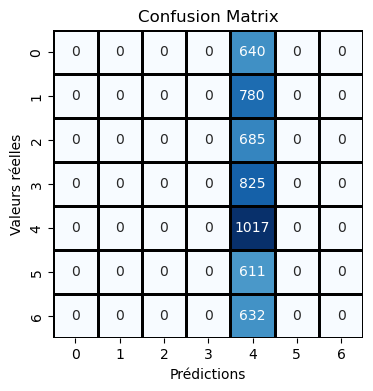

LogisticRegression


<IPython.core.display.Javascript object>

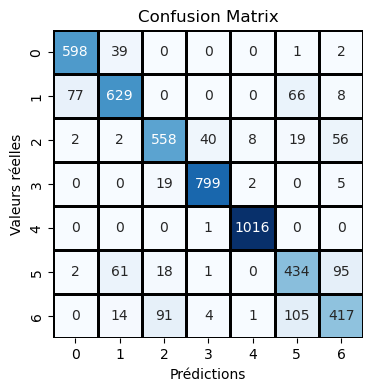

KNeighborsClassifier


<IPython.core.display.Javascript object>

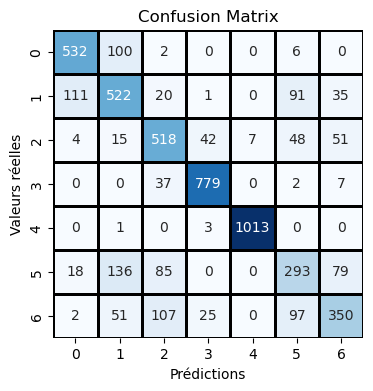

SGDClassifier


<IPython.core.display.Javascript object>

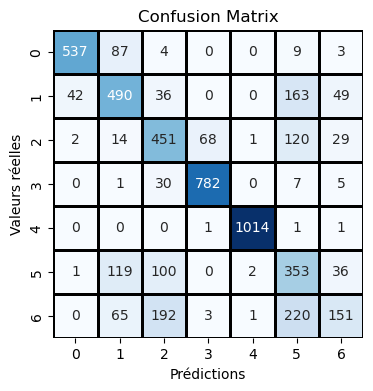

RandomForestClassifier


<IPython.core.display.Javascript object>

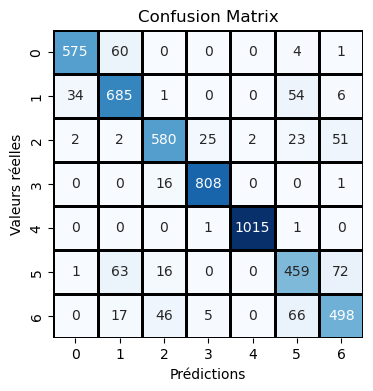

AdaBoostClassifier


<IPython.core.display.Javascript object>

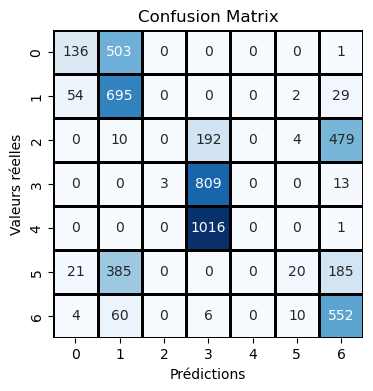

XGBClassifier


<IPython.core.display.Javascript object>

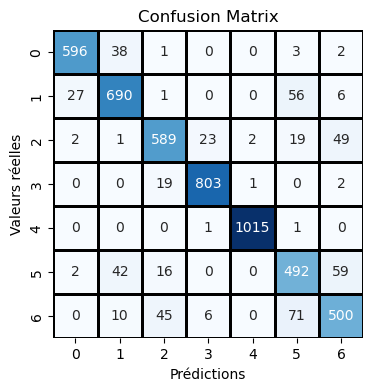

In [38]:
for i in df_prediction:
    print(i)
    matrice(df_prediction[i])
    

## ROC

DummyClassifier


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

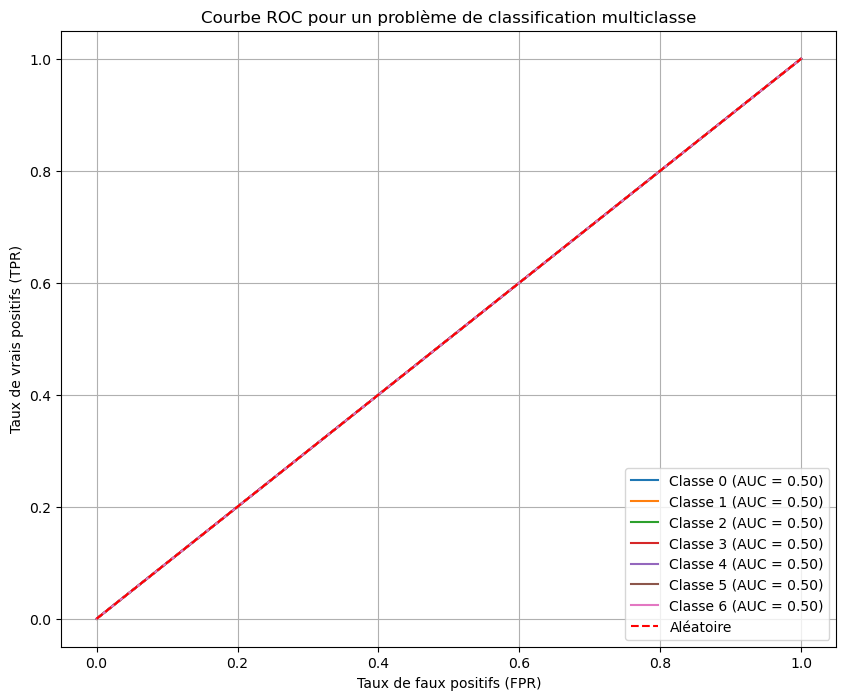

LogisticRegression


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

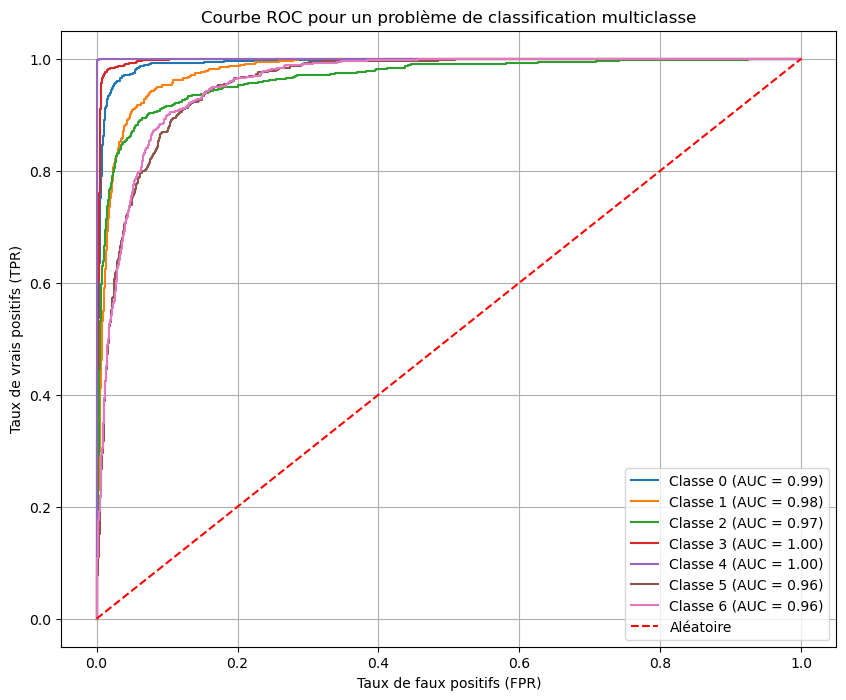

KNeighborsClassifier


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

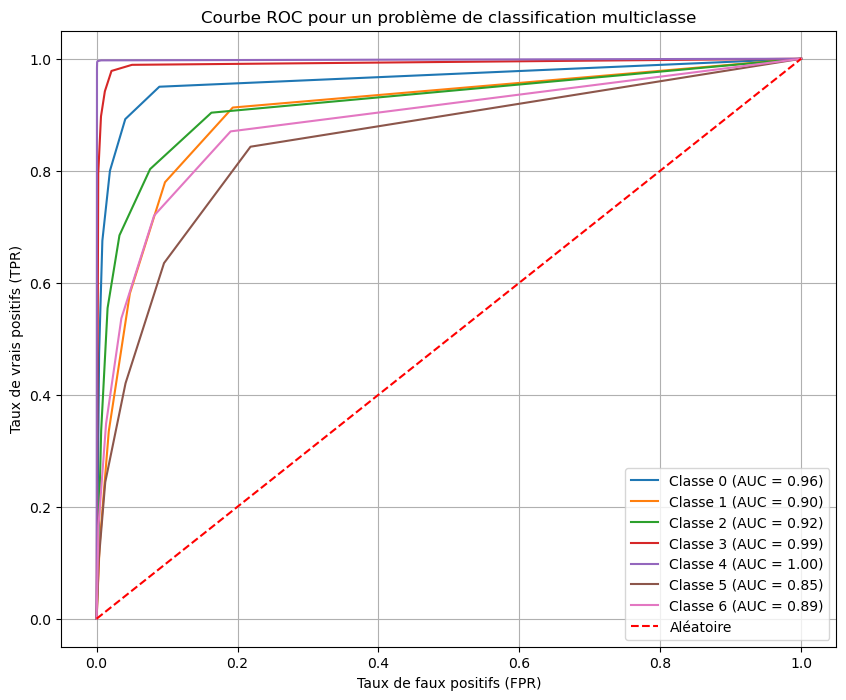

SGDClassifier


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

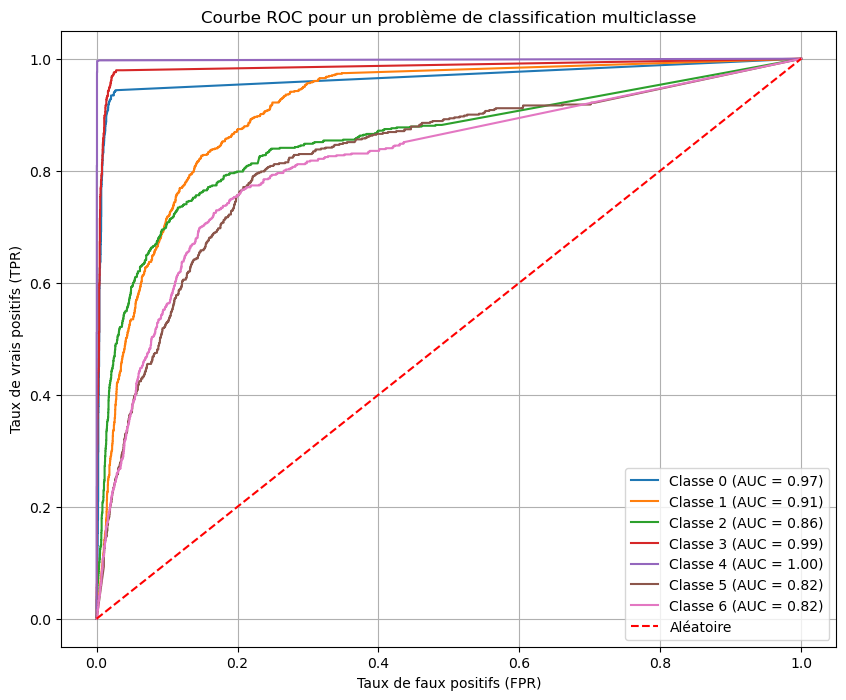

RandomForestClassifier


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

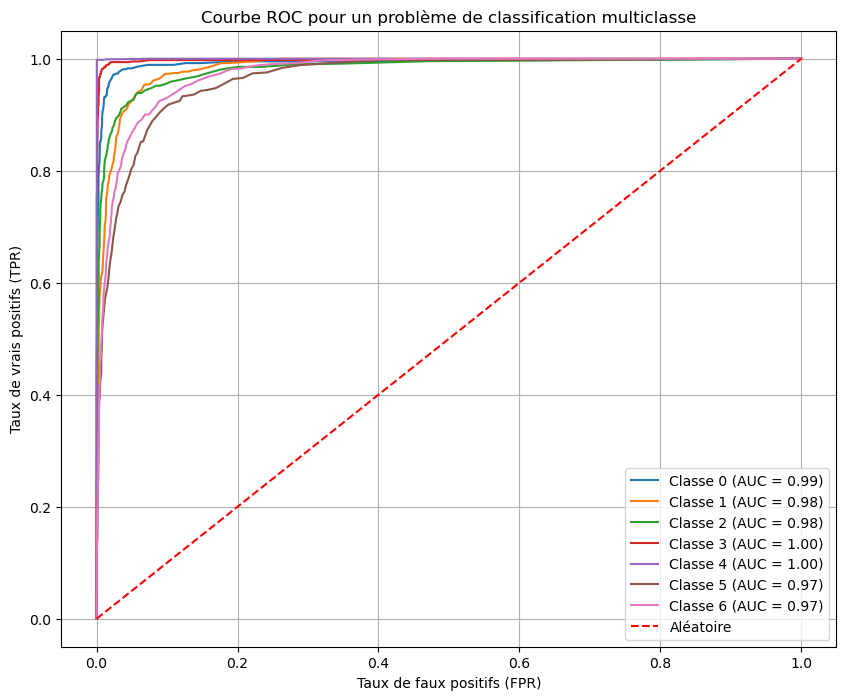

AdaBoostClassifier


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

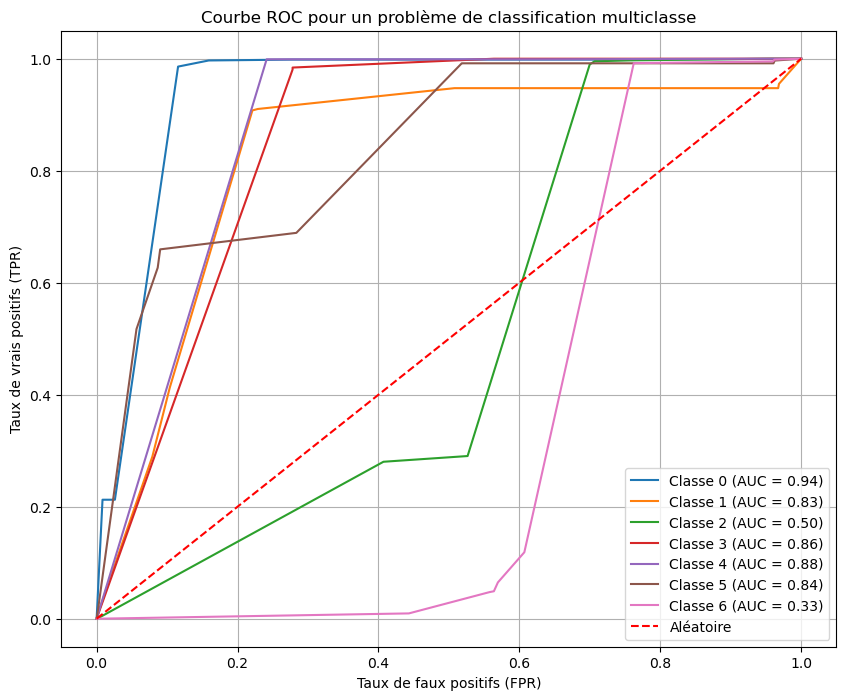

XGBClassifier


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

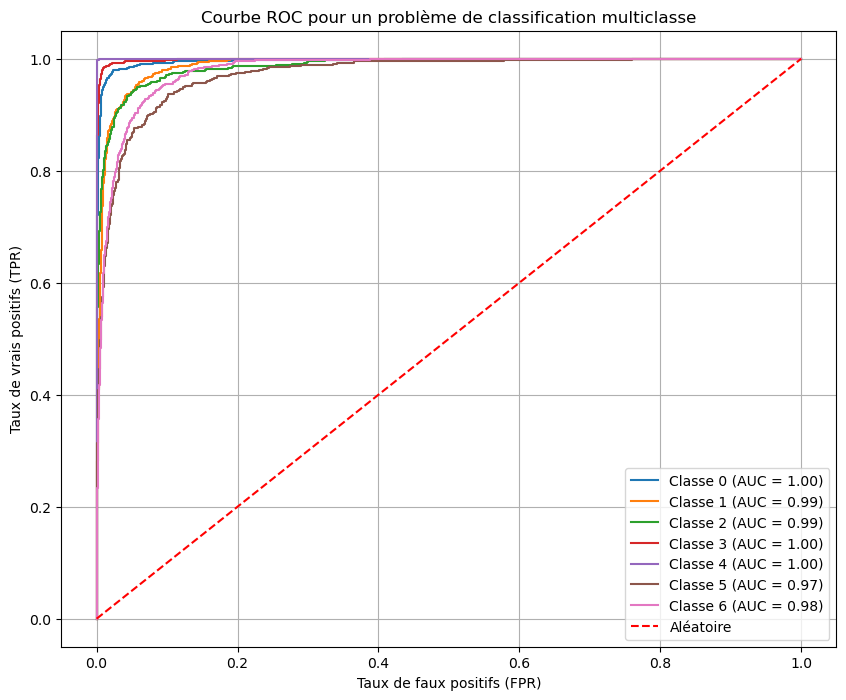

In [41]:
for i in dict_model_trained:
    print(i)
    ROC(dict_model_trained[i] )

## Amélioration du modèle par GridSearchCV :

#### Meilleur modèle de base : XGBClassifier

Nous allons tenter d'améliorer le modèle qui a eu le meilleur score sans gridsearch préalable

In [62]:
param_xgb = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [64]:
xgb_pred, xgb_time_exe, best_xgb = GRID(XGBClassifier(), param_xgb)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

XGBClassifier 

Durée d'entrainement : 13.19
Scores de chaque split: [0.9, 0.91, 0.89, 0.9, 0.91]
Meilleurs combinaison Grid : {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 180}


In [75]:
xgb_metric = metric(xgb_pred, "XGBClassifier_GRID", xgb_time_exe)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [78]:
pd.concat([xgb_metric.T, df_metrics[df_metrics.index == "XGBClassifier"]]).sort_values(by="F1",ascending=False)

,F1,accuracy,recall,precision,duree_entrainement(min)
XGBClassifier_GRID,0.904493,0.904432,0.904432,0.904678,13.19
XGBClassifier,0.902853,0.902697,0.902697,0.903203,0.03


## on observe une très légère amélioration après gridsearch, mais on passe de qlq secondes d'entrainement à 13 minutes pour l'obtenir


#### Sauvegarde du modèle :

In [ ]:

for i in dict_model_trained:
    model_name = i
    current_model = dict_model_trained[model_name]
    model_filename = os.path.join(path_trained_model, f"{model_name}.pkl")
    #Enregistrement des modèles préentrainé :
    with open(model_filename, 'wb') as model_file:
        pickle.dump(current_model, model_file)


In [83]:
#Récupération du chemin du modèle à enregistrer : 
path_save_model = os.path.join(path_trained_model,"XGBC_GRID.pkl")
with open(path_save_model,"wb") as model_file:
    pickle.dump(best_xgb, model_file)

<IPython.core.display.Javascript object>